# Определение возраста покупателей

# Содержание

* [Введение](#Введение)
* [Исследовательский анализ данных](#data_analysis)
* [Обучение модели](#training)
* [Анализ обученной модели](#conclusion)

# Введение
В данном проекте мы разработаем систему компьютерного зрения для обработки фотографий покупателей в супермаркете "Хлеб-Соль". Фотофиксация в прикассовой зоне поможет определять возраст клиентов, что позволит анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также контролировать продажу алкоголя к несовершеннолетним. Мы построим модель компьютерного зрения, которая сможет определять приблизительный возраст человека по фотографии. Для этого мы будем использовать набор фотографий людей с указанием возраста.

### План работы
* Изучим предоставленные данные
* Обучим модель (нужно добиться значение MAE не больше 8)
* Напишем вывод

## Исследовательский анализ данных
<a id='data_analysis'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
display(labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

In [4]:
age_stats = labels['real_age'].describe()
print(age_stats)

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


В данном датасете 7591 фотография. Датасет состоит из 2 полей: название файла (фотография) и реальный возраст человека. Минимальный возраст, отображенный на фотографии, составляет 1 год, а максимальный - 100 лет. Тем не менее, средний возраст людей в данном датасете составляет 31 год.

Рассмотрим 16 фотографий, выбранных случайным образом, чтобы убедиться в верности базы данных.

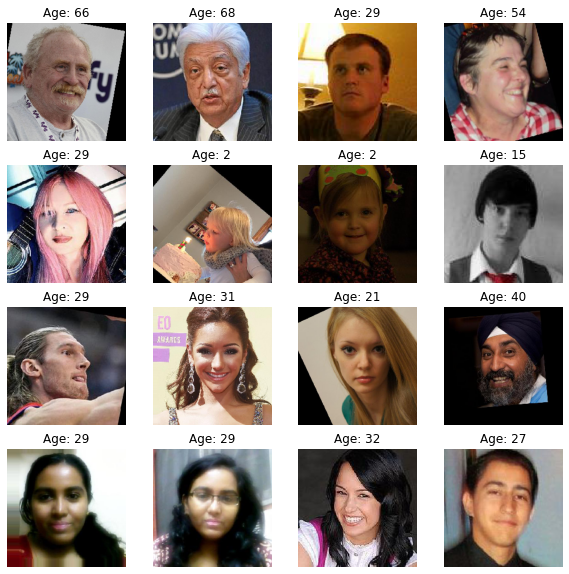

In [5]:
random_images = random.sample(range(len(train_gen_flow)), 16)

plt.figure(figsize=(10,10))
for i, image_index in enumerate(random_images):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(train_gen_flow[image_index][0][0])
    plt.title("Age: " + str(train_gen_flow[image_index][1][0]))
    plt.axis('off')

После нескольких просмотров фотографий и указанных возрастов, можно согласиться, что фотографии соответствуют возрасту запечатлённых людей. Таким образом, модель будет обучаться на достоверных данных.  

Построим графики возрастов, а также найдем медианный возраст.

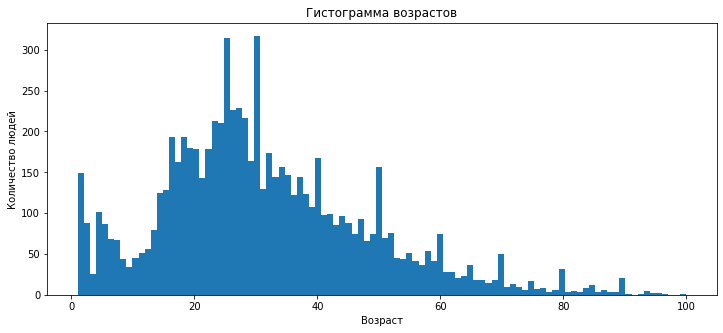

In [6]:
# График возрастов
plt.figure(figsize=(12,5))
plt.hist(labels['real_age'], bins=100)
plt.title('Гистограмма возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.show()

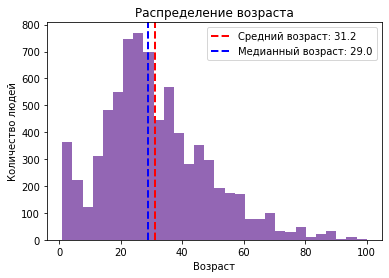

In [7]:
# Построение графика среднего и медианного возраста
mean_age = np.round(labels['real_age'].mean(), 2)
median_age = labels['real_age'].median()

plt.figure(figsize=(6, 4))
plt.hist(labels['real_age'], bins=30, color='indigo', alpha=0.6)
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Средний возраст: {mean_age}')
plt.axvline(median_age, color='blue', linestyle='dashed', linewidth=2, label=f'Медианный возраст: {median_age}')
plt.legend()
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.show()

И медианный, и средний возраст практически одинаковы. Медианный возраст (29 лет) находится в середине распределения возрастов.
В целом, данный датасет имеет относительно молодое поколение, что может быть важным фактором при анализе покупательского поведения и предложении товаров в сетевом супермаркете.

## Обучение модели
<a id='training'></a>

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
# < скопированный код >

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    Flatten
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
```

```python
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```python

# < скопированный результат вывода на экран >
# < длинные строки со скачиванием модели удалены >

 ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/30
2023-04-14 17:25:36.150041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-14 17:25:37.556549: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 102s - loss: 214.7686 - mae: 11.0750 - val_loss: 358.2427 - val_mae: 14.0986
Epoch 2/30
356/356 - 57s - loss: 133.8582 - mae: 8.8070 - val_loss: 200.1813 - val_mae: 11.0562
Epoch 3/30
356/356 - 76s - loss: 107.7545 - mae: 7.9925 - val_loss: 118.4812 - val_mae: 8.3159
Epoch 4/30
356/356 - 72s - loss: 89.0899 - mae: 7.2806 - val_loss: 215.9294 - val_mae: 10.6836
Epoch 5/30
356/356 - 57s - loss: 76.1132 - mae: 6.6328 - val_loss: 159.2011 - val_mae: 9.2167
Epoch 6/30
356/356 - 60s - loss: 66.8021 - mae: 6.2380 - val_loss: 104.9248 - val_mae: 7.6494
Epoch 7/30
356/356 - 57s - loss: 58.7423 - mae: 5.8754 - val_loss: 96.1950 - val_mae: 7.5226
Epoch 8/30
356/356 - 55s - loss: 46.4073 - mae: 5.2443 - val_loss: 88.9258 - val_mae: 7.1711
Epoch 9/30
356/356 - 54s - loss: 42.6582 - mae: 4.9856 - val_loss: 88.5794 - val_mae: 7.1325
Epoch 10/30
356/356 - 55s - loss: 34.5397 - mae: 4.5209 - val_loss: 114.5034 - val_mae: 7.9747
Epoch 11/30
356/356 - 54s - loss: 30.5548 - mae: 4.2844 - val_loss: 83.4461 - val_mae: 6.8678
Epoch 12/30
356/356 - 60s - loss: 29.7878 - mae: 4.2209 - val_loss: 103.9523 - val_mae: 7.9432
Epoch 13/30
356/356 - 76s - loss: 27.8228 - mae: 4.0987 - val_loss: 99.5028 - val_mae: 7.8792
Epoch 14/30
356/356 - 78s - loss: 23.0731 - mae: 3.7241 - val_loss: 103.1963 - val_mae: 7.6579
Epoch 15/30
356/356 - 53s - loss: 20.3114 - mae: 3.4776 - val_loss: 87.4423 - val_mae: 7.0942
Epoch 16/30
356/356 - 53s - loss: 21.5666 - mae: 3.5778 - val_loss: 84.7502 - val_mae: 7.1448
Epoch 17/30
356/356 - 54s - loss: 19.0721 - mae: 3.3531 - val_loss: 98.8335 - val_mae: 7.6748
Epoch 18/30
356/356 - 56s - loss: 18.7381 - mae: 3.3120 - val_loss: 85.8049 - val_mae: 7.0001
Epoch 19/30
356/356 - 56s - loss: 18.5002 - mae: 3.2953 - val_loss: 79.5761 - val_mae: 6.6438
Epoch 20/30
356/356 - 55s - loss: 16.1393 - mae: 3.0787 - val_loss: 102.8585 - val_mae: 7.6445
Epoch 21/30
356/356 - 52s - loss: 14.1315 - mae: 2.8586 - val_loss: 85.2944 - val_mae: 7.1201
Epoch 22/30
356/356 - 38s - loss: 13.7321 - mae: 2.8272 - val_loss: 79.8769 - val_mae: 6.7114
Epoch 23/30
356/356 - 38s - loss: 13.4765 - mae: 2.8125 - val_loss: 83.9978 - val_mae: 6.9336
Epoch 24/30
356/356 - 38s - loss: 13.3883 - mae: 2.8093 - val_loss: 71.0564 - val_mae: 6.3481
Epoch 25/30
356/356 - 38s - loss: 12.3623 - mae: 2.7253 - val_loss: 74.1627 - val_mae: 6.4338
Epoch 26/30
356/356 - 38s - loss: 12.0186 - mae: 2.6800 - val_loss: 80.9077 - val_mae: 6.6764
Epoch 27/30
356/356 - 38s - loss: 13.7291 - mae: 2.8288 - val_loss: 98.0195 - val_mae: 7.2709
Epoch 28/30
356/356 - 38s - loss: 12.6796 - mae: 2.7347 - val_loss: 80.3999 - val_mae: 6.6100
Epoch 29/30
356/356 - 38s - loss: 11.6773 - mae: 2.6342 - val_loss: 75.5415 - val_mae: 6.4724
Epoch 30/30
356/356 - 38s - loss: 11.2769 - mae: 2.5713 - val_loss: 114.5251 - val_mae: 7.7095
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 114.5251 - mae: 7.7095
Test MAE: 7.7095

```

## Анализ обученной модели
<a id='conclusion'></a>

Модель была протестирована на тестовых данных и показала среднюю абсолютную ошибку (MAE) 7.7095 в предсказании возраста людей. Это означает, что средняя ошибка предсказания возраста на тестовых данных составляет примерно 7.7 лет. Если предположить, что средний и медианные возрасты (29 лет и 31 год соответственно) совпадают с возрастами покупателей супермаркета "Хлеб-Соль", то можно отметить, что модель хорошо справляется с поставленной задачей, т.к. в данной возрастной категории, 7 лет не является существенным отличием.  
Поставленный результат (MAE не выше 8) был выполнен. В случае успешного опробирования, есть простор для дальнейшей работы над улучшением модели.